In [1]:
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from fastapi.responses import JSONResponse
from pymilvus import Collection, connections, FieldSchema, CollectionSchema, DataType
from dotenv import load_dotenv
import os
from bs4 import BeautifulSoup
import random
import json
from typing import List
from pydantic import BaseModel
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
from metaphone import doublemetaphone
from pymilvus import AnnSearchRequest
from pymilvus import WeightedRanker
import pandas as pd

load_dotenv()

# Connect to Zilliz Cloud
connections.connect(
    alias="default",
    uri=os.getenv("ZILLIZ_URI"),
    token=os.getenv("ZILLIZ_TOKEN")    
)


C:\Users\modip\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
collection_name = "Alphabetic_Sort_2"
collection=''
try:
    collection = Collection(name=collection_name)  
    collection.load()
    print("Collection exists.")
except Exception as e:
    # collection = Collection(name=collection_name, schema=schema) 
    print("Collection created.")


if connections.has_connection("default"):
    print("Connection successful!")
else:
    print("Failed to connect.")

Collection created.
Connection successful!


In [7]:
from pymilvus import Collection

collection_name = "Alphabetic_sort_2"
collection = Collection(collection_name)

schema = collection.schema
print("Current Schema:", schema)

Current Schema: {'auto_id': True, 'description': '', 'fields': [{'name': 'Auto_id', 'description': 'The Primary Key', 'type': <DataType.INT64: 5>, 'is_primary': True, 'auto_id': True}, {'name': 'Title_Name', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 1000}}, {'name': 'Title_Name_After_Sort', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 1000}}, {'name': 'Metaphone_Name_After_Sort', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 1000}}, {'name': 'Metaphone_Name_Without_Sorting', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 1000}}, {'name': 'Trans_Title_Sort_Name', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 1000}}, {'name': 'vector_of_metaphone', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 384}}, {'name': 'vector_of_name', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 384}}, 

In [9]:
entities = collection.query(expr="", output_fields=["*"])

RPC error: [query], <MilvusException: (code=1100, message=empty expression should be used with limit: invalid parameter)>, <Time:{'RPC start': '2024-12-12 01:17:06.002303', 'RPC error': '2024-12-12 01:17:06.298443'}>


MilvusException: <MilvusException: (code=1100, message=empty expression should be used with limit: invalid parameter)>

In [89]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [31]:
def get_metaphone(name):
    return doublemetaphone(name)[0]

In [ ]:
# Create ANN search request 1 for filmVector
# query_filmVector = [[0.8896863042430693, 0.370613100114602, 0.23779315077113428, 0.38227915951132996, 0.5997064603128835]]
nameVector=[model.encode("NEELI GAGAN SAMACHAR TIMES").tolist()]

search_param_1 = {
    "data": nameVector, # Query vector
    "anns_field": "vector_of_name", # Vector field name
    "param": {
        "metric_type": "COSINE", # This parameter value must be identical to the one used in the collection schema
        "params": {"nprobe": 384}
    },
    "limit": 200, # Number of search results to return in this AnnSearchRequest,
}
request_1 = AnnSearchRequest(**search_param_1)

# Create ANN search request 2 for posterVector
# query_posterVector = [[0.02550758562349764, 0.006085637357292062, 0.5325251250159071, 0.7676432650114147, 0.5521074424751443]]
metaphoneVector=[model.encode(get_metaphone('NEELI GAGAN SAMACHAR TIMES')).tolist()]
search_param_2 = {
    "data": metaphoneVector, # Query vector
    "anns_field": "vector_of_metaphone", # Vector field name
    "param": {
        "metric_type": "COSINE", # This parameter value must be identical to the one used in the collection schema
        "params": {"nprobe": 384}
    },
    "limit": 200, # Number of search results to return in this AnnSearchRequest
}
request_2 = AnnSearchRequest(**search_param_2)
print(request_1)
print(request_2)

# Store these two requests as a list in `reqs`
reqs = [request_1, request_2]

{'anns_field': 'vector_of_name', 'param': {'metric_type': 'COSINE', 'params': {'nprobe': 384}}, 'limit': 200, 'expr': None}
{'anns_field': 'vector_of_metaphone', 'param': {'metric_type': 'COSINE', 'params': {'nprobe': 384}}, 'limit': 200, 'expr': None}


In [33]:
rerank = WeightedRanker(0.8, 0.2)

In [41]:
results = collection.hybrid_search(
    reqs, # List of AnnSearchRequests created in step 1
    rerank, # Reranking strategy specified in step 2
    limit=200, # Number of final search results to return,
    output_fields=["Metaphone_Name","Title_Code","Title_Name"]
)

In [43]:
processed_results = []
for result in results[0]:
    processed_results.append({
        "distance": result.distance,
        "Metaphone_Name": result.entity.get("Metaphone_Name"),
        "Title_Code": result.entity.get("Title_Code"),
        "Title_Name": result.entity.get("Title_Name"),
    })

In [47]:
hybrid_search_results=pd.DataFrame(processed_results)

In [48]:
hybrid_search_results

,distance,Metaphone_Name,Title_Code,Title_Name
0,0.999999,ANSXTJTTMS,UPHIN30203,ANUSUCHIT JATI TIMES
1,0.866217,JKRTTMS,JKENG00746,JAGRATI TIMES
2,0.833722,ANXTMS,BIHHIN11744,ANIWESH TIMES
3,0.830987,JSRTTMS,DELURD02896,JASARAT TIMES
4,0.830987,JSRTTMS,DELBIL06518,JASARAT TIMES
...,...,...,...,...
195,0.165786,TSTJRTMS,MPHIN34395,DASTGEER TIMES
196,0.165721,JTXRTMS,RAJHIN27392,JODHESHWAR TIMES
197,0.165661,MJTTMS,UPHIN47530,MAJEET TIMES
198,0.165532,RXTRLKMTTMS,UPHIN49259,RASHTRIYA LOKMAT TIMES


In [69]:
def create_hybrid_results(name=0.8,meta=0.2,title="INDIAN"):
    processed_results = []
    nameVector=[model.encode(title).tolist()]
    metaphoneVector=[model.encode(get_metaphone(title)).tolist()]
    search_param_1 = {
    "data": nameVector, 
    "anns_field": "vector_of_name", 
    "param": {
        "metric_type": "COSINE", 
        "params": {"nprobe": 384}
    },
    "limit": 200,
    }
    search_param_2 = {
    "data": metaphoneVector, 
    "anns_field": "vector_of_metaphone", 
    "param": {
        "metric_type": "COSINE",
        "params": {"nprobe": 384}
    },
    "limit": 200,
    }
    reqs = [AnnSearchRequest(**search_param_1), AnnSearchRequest(**search_param_2)]
    rerank = WeightedRanker(name, meta)
    results = collection.hybrid_search(
    reqs,
    rerank,
    limit=200,
    output_fields=["Metaphone_Name","Title_Name",'Count']
    )
    for result in results[0]:
        processed_results.append({
            "distance": result.distance,
            "Metaphone_Name": result.entity.get("Metaphone_Name"),
            "Title_Name": result.entity.get("Title_Name"),
            "Count":result.entity.get("Count")
        })
    df=pd.DataFrame(processed_results)
    df=df.sort_values(by=['distance',"Count"],ascending=False)[:50]
    return df.loc[df['Count']>100]
    

In [ ]:
hybrid_search_results=create_hybrid_results(0.8,0.2,'AND')

In [86]:
entered_name="PERIN THE INDIAN"
for name in entered_name.split():
    result=create_hybrid_results(0.8,0.2,name)
    result=result.loc[result['distance']>0.80]
    if(result.shape[0]>0):
        print(f"the word {name} or similar to it matches with {((sum(result['Count'])*100)/10000)} of total names")
    # print(result)

the word THE or similar to it matches with 10.78 of total names
the word INDIAN or similar to it matches with 39.63 of total names


In [80]:
merged_df

,distance,Metaphone_Name,Title_Name,Count
0,0.999999,0,THE,1078.0
1,0.698457,N,NEW,132.0
2,0.594116,AL,ALL,128.0


In [23]:
word_counts=pd.read_csv('../dataFiles/word_counts.csv')

In [24]:
word_list=[]

In [25]:
for i in range(word_counts.shape[0]):
    name=word_counts.iloc[i]['Title_Name']
    count=word_counts.iloc[i]['Word_Count']
    word_list.append({
        'Title_Name':name,
        'Count':float(count),
        'Metaphone_Name':doublemetaphone(name)[0],
        'vector_of_name':model.encode(name).tolist(),
        'vector_of_metaphone':model.encode(doublemetaphone(name)[0]).tolist()
    })

In [26]:
output_json = {
    "rows": word_list
}
with open("word_count_two_vector.json", "w", encoding="utf-8") as json_file:
    json.dump(output_json, json_file, ensure_ascii=False, indent=4)

In [6]:
!pip install pronouncing

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/939.4 kB ? eta -:--:--
   ---------------------------------------- 939.4/939.4 kB 6.2 MB/s eta 0:00:00
  Created wheel for pronouncing: filename=pronouncing-0.2.0-py2.py3-none-any.whl size=6258 sha256=3e8453eb00788a7af9ac4cfecc1daba64d4a6d019b512181c13af68e8df5358e
  Stored in directory: c:\users\modip\appdata\local\pip\cache\wheels\05\f6\1d\599c67da1fa48c086d8c49e8fc6bd5f05bc9fa66fb04bed5db
Successfully built pronouncing


In [14]:
import pronouncing

# Example word
word = "progress"

# Get ARPAbet transcriptions for the word
pronunciations = pronouncing.phones_for_word(word)

# Print the first phoneme transcription
if pronunciations:
    print(f"ARPAbet phonemes for {word}: {pronunciations[0]}")
else:
    print(f"No ARPAbet transcription found for {word}")


ARPAbet phonemes for progress: P R AA1 G R EH2 S


In [24]:
import re

def get_phonetic_transcription(word):
    # Convert to lowercase for consistency
    word = word.lower()

    # Vowel mapping (ARPAbet)
    vowel_map = {
        'a': 'AE', 'e': 'EH', 'i': 'IH', 'o': 'AH', 'u': 'UH', 
        'ai': 'EY', 'ei': 'EY', 'oi': 'OY', 'ou': 'OW', 'au': 'AW',
        'oo': 'UW', 'ea': 'IY', 'ea': 'EH', 'ay': 'EY', 'ey': 'EH'
    }
    
    # Consonant mapping (ARPAbet)
    consonant_map = {
        'b': 'B', 'c': 'K', 'd': 'D', 'f': 'F', 'g': 'G', 
        'h': 'HH', 'j': 'JH', 'k': 'K', 'l': 'L', 'm': 'M', 
        'n': 'N', 'p': 'P', 'q': 'K', 'r': 'R', 's': 'S', 
        't': 'T', 'v': 'V', 'w': 'W', 'x': 'KS', 'y': 'Y', 'z': 'Z'
    }
    
    # Handling numbers: Convert numbers to phonetic representation
    number_map = {
        '0': 'Z', '1': 'W AH N', '2': 'T UW', '3': 'TH R IY', 
        '4': 'F AO R', '5': 'F AY V', '6': 'S IH K S', 
        '7': 'S EH V AH N', '8': 'EY T', '9': 'N AY N'
    }

    # Handle special characters like hyphens and exclamation marks by removing or replacing
    word = re.sub(r'[^\w\s]', '', word)  # Remove punctuation marks

    # Check if the word contains digits and convert them
    word_with_digits = " ".join([number_map.get(ch, ch) for ch in word if ch.isdigit()])

    # Handle vowels and consonants for the word
    for vowel_pair, phoneme in vowel_map.items():
        word = re.sub(vowel_pair, phoneme, word)
    
    # Replace consonants
    phonetic_word = ''.join([consonant_map.get(char, char) for char in word])

    # Apply stress (simplified rule for example)
    if word in ["progress", "record"]:
        phonetic_word = re.sub(r'([AEIOU])', r'\1(1)', phonetic_word, count=1)  # Primary stress on first vowel
    
    return phonetic_word.upper()

# Example usage
word_list = ["Hello", "world", "ONE23", "2008", "boom!", "kweezlebotter"]

lexicon = {}
for word in word_list:
    phonetic_transcription = get_phonetic_transcription(word)
    lexicon[word] = phonetic_transcription

# Print lexicon
for word, transcription in lexicon.items():
    print(f"{word} -> {transcription}")


Hello -> HHEHLLAH
world -> WAHRLD
ONE23 -> AHNEH23
2008 -> 2008
boom! -> BAHAHM
kweezlebotter -> KWEHEHZLEHBAHTTEHR


In [164]:
import pandas as pd
df = pd.read_csv("timeTest.csv")

In [165]:
lmax = df["Meta_Levensthein"].max()

In [166]:
df['Meta_Levensthein'] = lmax - df['Meta_Levensthein']

In [167]:
df

,distance,Metaphone_Name_After_Sort,Title_Name,Title_Name_After_Sort,fuzzy,Meta_Levensthein
0,0.902795,RNPTMS,TIMES OF RANIP,RANIP TIMES,53,8
1,0.902795,RNPTMS,TIMES OF RANIP,RANIP TIMES,53,8
2,0.793185,ASKXP,KASHYAP AWAZ,AWAZ KASHYAP,24,7
3,0.789403,KMLPTRNTMS,RANI KAMLAPATI TIMES,KAMLAPATI RANI TIMES,40,3
4,0.783015,TMSSN,ZAYAAN TIMES,TIMES ZAYAAN,35,6
5,0.765987,ASSMTR,ZAMIDAR AWAZ,AWAZ ZAMIDAR,24,5
6,0.763309,ASKST,ZAIDI KI AWAZ,AWAZ KI ZAIDI,22,6
7,0.758529,ASKSMR,ZAMIR KI AWAZ,AWAZ KI ZAMIR,22,5
8,0.754045,ASXPR,AWAZ E SHAHPUR,AWAZ E SHAHPUR,21,7
9,0.753576,ARXXTLTMS,SHAHDOL ARSH TIMES,ARSH SHAHDOL TIMES,17,3


In [168]:
from sklearn.preprocessing import MinMaxScaler
scalar=MinMaxScaler()
columns_to_normalize = ['distance', 'fuzzy', 'Meta_Levensthein']

# Apply MinMaxScaler to selected columns
df[columns_to_normalize] = scalar.fit_transform(df[columns_to_normalize])
df

,distance,Metaphone_Name_After_Sort,Title_Name,Title_Name_After_Sort,fuzzy,Meta_Levensthein
0,1.000000,RNPTMS,TIMES OF RANIP,RANIP TIMES,1.000000,1.000
1,1.000000,RNPTMS,TIMES OF RANIP,RANIP TIMES,1.000000,1.000
2,0.454174,ASKXP,KASHYAP AWAZ,AWAZ KASHYAP,0.325581,0.875
3,0.435344,KMLPTRNTMS,RANI KAMLAPATI TIMES,KAMLAPATI RANI TIMES,0.697674,0.375
4,0.403531,TMSSN,ZAYAAN TIMES,TIMES ZAYAAN,0.581395,0.750
5,0.318738,ASSMTR,ZAMIDAR AWAZ,AWAZ ZAMIDAR,0.325581,0.625
6,0.305403,ASKST,ZAIDI KI AWAZ,AWAZ KI ZAIDI,0.279070,0.750
7,0.281596,ASKSMR,ZAMIR KI AWAZ,AWAZ KI ZAMIR,0.279070,0.625
8,0.259269,ASXPR,AWAZ E SHAHPUR,AWAZ E SHAHPUR,0.255814,0.875
9,0.256931,ARXXTLTMS,SHAHDOL ARSH TIMES,ARSH SHAHDOL TIMES,0.162791,0.375


In [169]:
distance = df['distance']
fuzzy = df['fuzzy']
l = df['Meta_Levensthein']

In [170]:
df['sim']= 0.5*fuzzy + 0.45*distance + 0.05*l 
srt=df.sort_values(by="sim", ascending=0)

In [171]:
pd.set_option('display.max_rows', None)
srt.head(100)

,distance,Metaphone_Name_After_Sort,Title_Name,Title_Name_After_Sort,fuzzy,Meta_Levensthein,sim
0,1.000000,RNPTMS,TIMES OF RANIP,RANIP TIMES,1.000000,1.000,1.000000
1,1.000000,RNPTMS,TIMES OF RANIP,RANIP TIMES,1.000000,1.000,1.000000
3,0.435344,KMLPTRNTMS,RANI KAMLAPATI TIMES,KAMLAPATI RANI TIMES,0.697674,0.375,0.563492
4,0.403531,TMSSN,ZAYAAN TIMES,TIMES ZAYAAN,0.581395,0.750,0.509787
14,0.225091,TMSSPRN,ZABARWAN TIMES,TIMES ZABARWAN,0.744186,0.625,0.504634
20,0.201866,ANTPRM,INDIA PRIME,INDIA PRIME,0.651163,0.875,0.460171
19,0.201866,ANTPRM,INDIA PRIME,INDIA PRIME,0.651163,0.875,0.460171
17,0.216762,TMSSMN,ZAMAN TIMES,TIMES ZAMAN,0.651163,0.625,0.454374
16,0.216762,TMSSMN,ZAMAN TIMES,TIMES ZAMAN,0.651163,0.625,0.454374
15,0.216762,TMSSMN,ZAMAN TIMES,TIMES ZAMAN,0.651163,0.625,0.454374


In [172]:
srt['distance'].iloc[::10]

0      1.000000
35     0.160759
33     0.165330
52     0.124213
34     0.164824
170    0.027457
69     0.105180
81     0.089210
12     0.236983
26     0.185572
38     0.147029
105    0.057887
195    0.001150
44     0.139250
194    0.001412
70     0.098162
87     0.077128
144    0.037660
126    0.042053
177    0.018068
Name: distance, dtype: float64

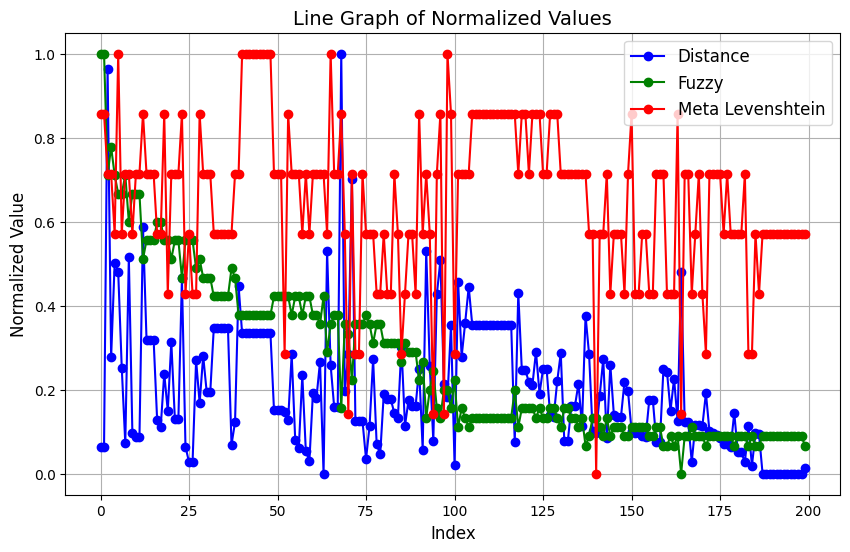

In [153]:
srt.reset_index(drop=True, inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(srt.index, srt['distance'], label='Distance', marker='o', linestyle='-', color='blue')
plt.plot(srt.index, srt['fuzzy'], label='Fuzzy', marker='o', linestyle='-', color='green')
plt.plot(srt.index, srt['Meta_Levensthein'], label='Meta Levenshtein', marker='o', linestyle='-', color='red')

# Customize the plot
plt.title("Line Graph of Normalized Values", fontsize=14)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Normalized Value", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
